### Computational Intelligence - Project 1 - 9931xx6

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### نکات پیاده سازی :
 به منظور رعایت قوانین پیاده سازی پروژه از کتابخانه *پایتورچ* فقط برای لود کردن دیتاست استفاده گردیده است. متباقی موارد که شامل آموزش
مدل نیز هست بطور کامل توسط کتابخانه Mytorch پیاده سازی شده است.


##### پیاده سازی قسمت هایی از فاز دوم پروژه مانند چگونگی آموزش داده ها و نمایش آن بر روی نمودار از فاز اول پروژه الهام گرفته شده است.

In [1]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Project1/mytorch/')
import os

import pandas as pd
import torch
from tensor import Tensor
from torch.utils.data.dataset import Dataset
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pylab as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
class CSVDataset(Dataset):
    def __init__(self, path: str):
        self.data = pd.get_dummies(pd.read_csv(path), columns=['Species']).astype(float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.iloc[idx]
        features = Tensor(row[:-3].values)
        label = Tensor([row.iloc[-3],row.iloc[-2],row.iloc[-1]])
        return features, label

    @property
    def classes(parameter_list):
        return ['Iris-setosa','Iris-versicolor','Iris-virginica']


path_train = 'Iris-Train.csv'
path_test = 'Iris-Test.csv'

dataset_train = CSVDataset(path_train)
dataset_test = CSVDataset(path_test)

In [4]:
from torch.utils.data import DataLoader
import numpy as np

def custom_collate_fn(batch):
    features = np.array([item[0].data for item in batch])
    labels = np.array([item[1].data for item in batch])

    return Tensor(features), Tensor(labels)

#TODO set parameters
loader_train = DataLoader(
    dataset=dataset_train,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)

loader_test = DataLoader(
    dataset=dataset_test,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)


In [5]:
print(f"batch   size\t= {loader_train.batch_size}")
print(f"train   size\t= {len(dataset_train):,}")
print(f"test    size\t= {len(dataset_test):,}")
print(f"Class   names\t= {dataset_train.classes}")

batch   size	= 16
train   size	= 105
test    size	= 60
Class   names	= ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


In [6]:
from myModel import MyModel

mymodel = MyModel()
MyModel.summary(self=mymodel)

linear1:  linear - total param: 128 - in: 4, out: 32
linear2:  linear - total param: 512 - in: 32, out: 16
linear3:  linear - total param: 48 - in: 16, out: 3


In [7]:
from loss import CategoricalCrossEntropy
from optimizer import SGD

def one_epoch_learning(
    model: MyModel,
    criterion: CategoricalCrossEntropy,
    loader: DataLoader,
    optimizer: SGD,
) -> int:
    accs = 0
    for data, label in loader:
        optimizer.zero_grad()

        res: Tensor = mymodel(data)
        loss: Tensor = CategoricalCrossEntropy(res, label)

        loss.backward()
        
        optimizer.step()

        accs += (res.data.argmax(axis=1) == label.data.argmax(axis=1)).sum().item()

    return accs

In [9]:
def calculate_accuracy(
    model: MyModel, loader: DataLoader, criterion: CategoricalCrossEntropy
) -> int:
    accs = 0
    for data, label in loader:
        res: Tensor = model(data)
        accs += (res.data.argmax(axis=1) == label.data.argmax(axis=1)).sum().item()
    return accs

In [10]:
def train(
    model: MyModel,
    criterion: CategoricalCrossEntropy,
    loader_train: DataLoader,
    loader_test: DataLoader,
    optimizer: SGD,
    epoch: int,
):
    results_train = []
    results_test = []

    for i in tqdm(range(epoch)):
        res_train = one_epoch_learning(model, criterion, loader_train, optimizer)
        results_train.append(res_train / len(loader_train.dataset))
        res_test = calculate_accuracy(model, loader_test, criterion)
        results_test.append(res_test / len(loader_test.dataset))
    return results_train, results_test

In [17]:
from loss import CategoricalCrossEntropy

EPOCH = 50

optimizer = SGD(MyModel.parameters(mymodel))
loss = CategoricalCrossEntropy

train_accs, test_accs = train(mymodel, loss, loader_train, loader_test, optimizer, EPOCH)

100%|██████████| 50/50 [00:00<00:00, 59.19it/s]


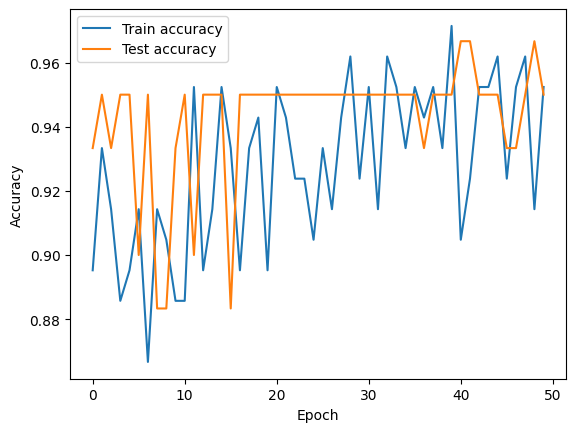

In [18]:
plt.plot(train_accs, label="Train accuracy")
plt.plot(test_accs, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
print(f"final train acc = {train_accs[-1]:.5f}")
print(f"final test acc = {test_accs[-1]:.5f}")
print(f"max train acc = {max(train_accs):.5f}")
print(f"max test acc = {max(test_accs):.5f}")
print(f"min train acc = {min(train_accs):.5f}")
print(f"min test acc = {min(test_accs):.5f}")

final train acc = 0.95238
final test acc = 0.95000
max train acc = 0.97143
max test acc = 0.96667
min train acc = 0.86667
min test acc = 0.88333
